## Configuración del entorno

Antes de comenzar con el desarrollo del modelo, se verificó la versión de las principales librerías utilizadas en el proyecto: NumPy, OpenCV y TensorFlow. Esto es importante para asegurar compatibilidad entre los módulos (por ejemplo, evitar errores entre versiones nuevas de NumPy y compilaciones anteriores de OpenCV o TensorFlow), y también para poder reproducir los resultados en el futuro.

En esta celda se importan las librerías y se imprimen sus versiones instaladas en el entorno de trabajo.


In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
print("NumPy:", np.__version__)
print("OpenCV:", cv2.__version__)
print("TensorFlow:", tf.__version__)


NumPy: 1.26.4
OpenCV: 4.11.0
TensorFlow: 2.20.0


## Carga del dataset MNIST

Para el entrenamiento del modelo se utilizó el conjunto de datos **MNIST**, un dataset estándar en problemas de reconocimiento de dígitos escritos a mano. MNIST contiene:

- **60,000 imágenes** para entrenamiento  
- **10,000 imágenes** para prueba  
- Cada imagen tiene un tamaño de **28 × 28 píxeles** en escala de grises  
- Las etiquetas corresponden a los dígitos del **0 al 9**

En esta celda se realiza la carga del dataset mediante `mnist.load_data()`, que devuelve los conjuntos de entrenamiento y prueba ya separados, listos para su procesamiento posterior.


In [12]:
# Import dataset
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

## Inspección de las dimensiones del dataset

Después de cargar MNIST, se revisan las dimensiones de los arreglos para confirmar que los datos se hayan importado correctamente y que su estructura coincida con la esperada por los modelos.

Los resultados muestran:

- `train_images.shape`: indica que hay **60,000 imágenes de entrenamiento**, cada una de tamaño **28×28 píxeles**.
- `train_labels.shape`: contiene **60,000 etiquetas**, una por cada imagen de entrenamiento.
- `test_images.shape`: corresponde a **10,000 imágenes de prueba**, también de **28×28 píxeles**.
- `test_labels.shape`: contiene las **10,000 etiquetas** asociadas a las imágenes de prueba.

Verificar estas dimensiones es un paso clave antes del preprocesamiento, ya que asegura que los datos están completos y tienen el formato adecuado para entrenar la red neuronal.


In [13]:
# Print the shape of data
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Testing images shape: {test_images.shape}")
print(f"Testing labels shape: {test_labels.shape}")

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Testing images shape: (10000, 28, 28)
Testing labels shape: (10000,)


## Distribución de clases en el conjunto de entrenamiento y prueba

Para verificar que el dataset esté balanceado, se analizó la cantidad de ejemplos disponibles para cada dígito (0–9) tanto en el conjunto de entrenamiento como en el de prueba.  
Esto se realizó utilizando `np.unique()` para obtener las clases y la cantidad de muestras por cada una, y posteriormente graficando los resultados en un histograma.

Los gráficos muestran que **todas las clases tienen una cantidad similar de ejemplos**, lo cual es ideal para el entrenamiento de un modelo de clasificación, ya que evita sesgos hacia una clase en particular.  
Esta distribución equilibrada garantiza que el modelo aprenda de manera uniforme a reconocer todos los dígitos.


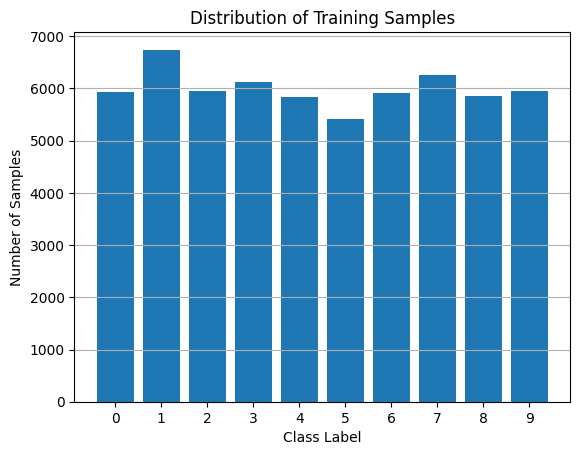

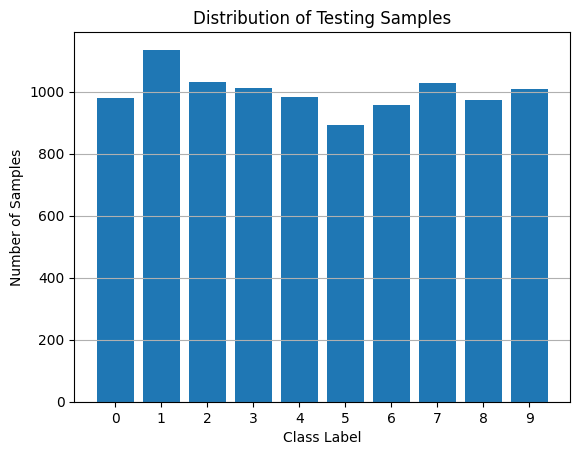

In [14]:
# Check class proportions
unique, counts = np.unique(train_labels, return_counts=True)
plt.bar(unique, counts, tick_label=unique)
plt.title('Distribution of Training Samples')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.grid(axis='y')
plt.show()

unique, counts = np.unique(test_labels, return_counts=True)
plt.bar(unique, counts, tick_label=unique)
plt.title('Distribution of Testing Samples')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.grid(axis='y')
plt.show()


## Visualización de ejemplos del conjunto de entrenamiento

Antes de entrenar el modelo, es útil observar algunas imágenes reales del dataset para confirmar que los datos tienen el formato esperado.  
En esta sección se muestran las primeras diez imágenes del conjunto de entrenamiento junto con sus etiquetas correspondientes.

Cada imagen es un dígito escrito a mano en **escala de grises**, con tamaño **28 × 28 píxeles**.  
Esta visualización permite verificar:

- que las imágenes están correctamente cargadas,
- que los dígitos son legibles,
- que no existen valores corruptos o mal formateados.

Además, proporciona una referencia visual del tipo de patrones que la red neuronal deberá aprender a identificar.


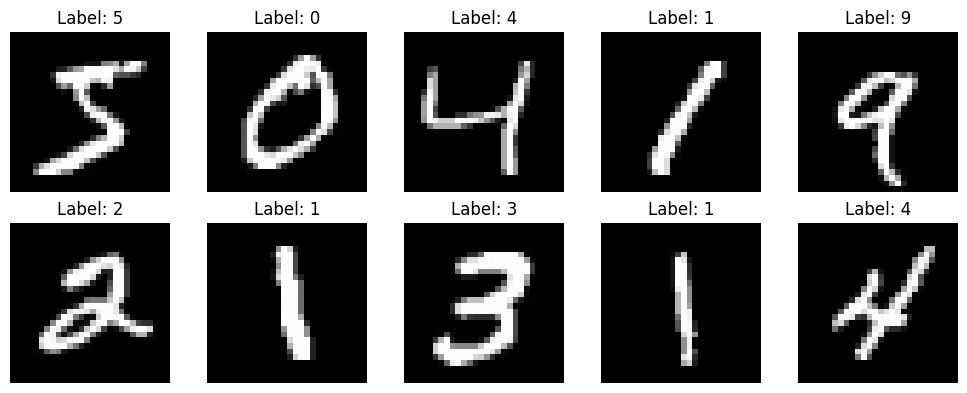

In [15]:
# Plotting first few images from the training set
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[i], cmap="gray")
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')  # Turn off axis numbers
plt.tight_layout()
plt.show()

## Verificación del rango de valores de los píxeles

Como parte del preprocesamiento, se revisó el rango de valores presente en las imágenes del conjunto de entrenamiento.  
Al imprimir el valor mínimo y máximo de los píxeles, se confirmó que estos se encuentran entre **0 y 255**, lo cual corresponde al formato estándar de imágenes en escala de grises.

Esta verificación es importante porque:

- asegura que los datos están en el rango esperado antes de normalizarlos,
- evita errores al aplicar operaciones como la división para escalar valores a `[0,1]`,
- permite confirmar que no existan valores atípicos o imágenes corruptas.

Esta información sirve como base para los pasos de normalización utilizados en el entrenamiento del modelo.


In [16]:
# Range of the data
print(f"Min pixel value in training set: {train_images.min()}")
print(f"Max pixel value in training set: {train_images.max()}")

Min pixel value in training set: 0
Max pixel value in training set: 255


## Modelo base: Red neuronal totalmente conectada (MLP)

Para comenzar, se construyó un modelo base utilizando una red neuronal totalmente conectada (*Multilayer Perceptron*, MLP).  
Este tipo de arquitectura sirve como punto de referencia, ya que permite comparar posteriormente el efecto de distintas mejoras.

El modelo está compuesto por:

- **Capa de entrada:** se aplanan las imágenes de `28 × 28` píxeles a un vector de 784 valores mediante la capa `Flatten`.
- **Capa densa oculta 1:** 128 neuronas con activación *ReLU*, encargadas de aprender patrones no lineales.
- **Capa densa oculta 2:** 64 neuronas con activación *ReLU*, que permiten refinar las representaciones aprendidas.
- **Capa de salida:** 10 neuronas con activación *softmax*, cada una correspondiente a un dígito del 0 al 9.

El modelo se entrenó usando el optimizador **Adam** con una tasa de aprendizaje de `0.0001`, y la función de pérdida utilizada fue  
`sparse_categorical_crossentropy`, adecuada para problemas de clasificación multiclase con etiquetas enteras.

La llamada a `model.summary()` muestra la arquitectura final, indicando la cantidad de parámetros entrenables en cada capa.


In [17]:
# Import keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Create simple feedforward neural network
model = Sequential()
# Input Layer: Flatten the 28x28 image data
model.add(Flatten(input_shape=(28, 28)))
# Hidden Layer 1: 128 units with ReLU activation
model.add(Dense(128, activation='relu'))
# Hidden Layer 2: 64 units with ReLU activation
model.add(Dense(64, activation='relu'))
# Output Layer: 10 units for 10 classes with softmax activation for probability distribution
model.add(Dense(10, activation='softmax'))
# Specify optimizer
opt = Adam(learning_rate=0.0001)
# Compile the model
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Print a summary of the model's architecture
model.summary()

c:\Users\nelso\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del modelo y uso de Early Stopping

Para entrenar el modelo base, se utilizaron 50 épocas como límite máximo.  
Sin embargo, se incorporó la técnica de **Early Stopping**, que permite detener el entrenamiento automáticamente cuando el modelo deja de mejorar en el conjunto de validación.

En este caso se configuró:

- `monitor='val_accuracy'`: se vigila la exactitud en la validación.
- `patience=4`: si la métrica no mejora durante 4 épocas consecutivas, se detiene el entrenamiento.
- `restore_best_weights=True`: al finalizar, el modelo recupera los pesos correspondientes a la mejor época.

Además, se reservó automáticamente un **40% de los datos de entrenamiento** como conjunto de validación (`validation_split=0.4`).  
Esto permite evaluar el rendimiento del modelo en datos que no ve durante el entrenamiento sin necesidad de un conjunto adicional.

El entrenamiento se realizó con un tamaño de lote (`batch_size`) de 80 imágenes.  
Los resultados del proceso quedaron almacenados en la variable `history`, permitiendo posteriormente graficar la evolución del desempeño.


In [18]:
# Create early stoppingg callback
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
# Training the model

history = model.fit(train_images, train_labels, epochs=50, validation_split=0.4, batch_size=80, callbacks=[early_stop])

Epoch 1/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6352 - loss: 12.9611 - val_accuracy: 0.7975 - val_loss: 4.3779
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8337 - loss: 3.1993 - val_accuracy: 0.8465 - val_loss: 2.7497
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8751 - loss: 1.9791 - val_accuracy: 0.8724 - val_loss: 2.1103
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8971 - loss: 1.4137 - val_accuracy: 0.8863 - val_loss: 1.7664
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9144 - loss: 1.0335 - val_accuracy: 0.8927 - val_loss: 1.5274
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9252 - loss: 0.7944 - val_accuracy: 0.9012 - val_loss: 1.3705
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9354 - loss: 0.6047 - val_accuracy: 0.9068 - val_loss: 1.2655
Epoch 8/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9449 - loss: 0.4680 - val_accuracy: 0

## Modelo con regularización: Dropout y penalización L2

Con el objetivo de reducir el sobreajuste observado en el modelo base, se implementó una segunda versión del modelo incorporando dos técnicas de regularización: **Dropout** y **penalización L2**.

### 🔹 Penalización L2 (`kernel_regularizer=regularizers.l2(1e-4)`)
La regularización L2 penaliza pesos demasiado grandes durante el entrenamiento.  
Esto obliga al modelo a aprender representaciones más suaves y estables, evitando que memorice ejemplos específicos del conjunto de entrenamiento.

En este modelo se aplicó L2 con un valor de `1e-4` en ambas capas densas ocultas.

### 🔹 Dropout (`Dropout(0.5)`)
Dropout desactiva aleatoriamente un 50% de las neuronas durante cada paso del entrenamiento.  
Esto obliga al modelo a no depender de rutas específicas de activación, reduciendo así drásticamente el riesgo de sobreajuste y mejorando la generalización.

### 🔹 Arquitectura del modelo regularizado
- `Flatten` para convertir cada imagen 28×28 en un vector.
- `Dense(128, relu)` con penalización L2.
- `Dropout(0.5)`
- `Dense(64, relu)` con penalización L2.
- `Dropout(0.5)`
- `Dense(10, softmax)` para la clasificación final.

### 🔹 Entrenamiento
Se utilizaron las mismas condiciones que en el modelo base:
- 50 épocas como máximo,
- `validation_split=0.4`,
- `batch_size=80`,
- y **Early Stopping** para conservar los mejores pesos.

### 🔹 Evaluación en el conjunto de prueba
Al finalizar el entrenamiento, se evaluó el rendimiento en el conjunto de prueba.  
Los resultados obtenidos fueron:

- **Exactitud en test:** `test_acc_reg`  
- **Pérdida en test:** `test_loss_reg`

Este modelo suele presentar mejor capacidad de generalización gracias a la regularización, incluso si la exactitud no aumenta drásticamente respecto al modelo base. Lo más importante es que el comportamiento del modelo se vuelve más estable y menos propenso al sobreajuste.


In [19]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Modelo 1: mismo que el base pero con Dropout y L2
model_reg = Sequential()
model_reg.add(Flatten(input_shape=(28, 28)))
model_reg.add(Dense(128, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-4)))
model_reg.add(Dropout(0.5))
model_reg.add(Dense(64, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-4)))
model_reg.add(Dropout(0.5))
model_reg.add(Dense(10, activation='softmax'))

opt_reg = Adam(learning_rate=0.0001)

model_reg.compile(optimizer=opt_reg,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model_reg.summary()

history_reg = model_reg.fit(
    train_images, train_labels,
    epochs=50,
    validation_split=0.4,
    batch_size=80,
    callbacks=[early_stop]
)

test_loss_reg, test_acc_reg = model_reg.evaluate(test_images, test_labels)
print("Exactitud en test (modelo con Dropout+L2):", test_acc_reg)
print("Pérdida en test (modelo con Dropout+L2):", test_loss_reg)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2176 - loss: 55.4427 - val_accuracy: 0.4024 - val_loss: 4.3307
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2059 - loss: 5.9243 - val_accuracy: 0.2824 - val_loss: 2.4338
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1792 - loss: 2.9388 - val_accuracy: 0.2310 - val_loss: 2.2432
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1749 - loss: 2.5098 - val_accuracy: 0.2210 - val_loss: 2.1814
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.4046 - loss: 4.0650
Exactitud en test (modelo con Dropout+L2): 0.40459999442100525
Pérdida en test (modelo con Dropout+L2): 4.06500244140625


## Aumento de datos (Data Augmentation)

Además de la regularización mediante Dropout y penalización L2, se aplicó una técnica adicional para mejorar la capacidad de generalización del modelo: **Data Augmentation**.

MNIST es un dataset relativamente sencillo, pero los dígitos escritos a mano en condiciones reales pueden presentar variaciones en orientación, tamaño y posición.  
El aumento de datos permite simular estas variaciones generando versiones modificadas de las imágenes originales durante el entrenamiento.

### 🔹 Preparación de los datos
Las imágenes originales, de tamaño `28 × 28`, se expandieron para incluir un canal adicional, pasando de `(28, 28)` a `(28, 28, 1)`, tal como requieren las arquitecturas que trabajan con imágenes en formato tensorial.

Posteriormente, se dividió el conjunto de entrenamiento en:
- **80% para entrenamiento**,  
- **20% para validación**,  
manteniendo así coherencia con la estructura utilizada en los modelos anteriores.

### 🔹 Transformaciones aplicadas
Con `ImageDataGenerator` se configuraron las siguientes modificaciones aleatorias:

- **rotation_range=10** → rota las imágenes hasta ±10°  
- **zoom_range=0.1** → aplica zoom aleatorio hasta un 10%  
- **width_shift_range=0.1** → desplaza la imagen horizontalmente  
- **height_shift_range=0.1** → desplaza la imagen verticalmente  

Estas variaciones simulan las diferencias naturales en la escritura manual, evitando que el modelo aprenda únicamente la forma exacta de los ejemplos de entrenamiento.

Finalmente, el generador se ajustó a los datos mediante `datagen.fit(X_train)` para preparar el pipeline de entrenamiento con imágenes aumentadas de manera continua.


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np

# Añadir canal para trabajar con (28, 28, 1)
train_images_da = train_images[..., np.newaxis]
test_images_da = test_images[..., np.newaxis]

# Separar train / validation (40% de validación para ser consistente)
X_train, X_val, y_train, y_val = train_test_split(
    train_images_da, train_labels, test_size=0.2, random_state=42
)

# Configurar data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

datagen.fit(X_train)


## Evaluación del modelo base en el conjunto de prueba

Una vez finalizado el entrenamiento, se evaluó el rendimiento del modelo base utilizando el **conjunto de prueba**, el cual contiene datos nunca vistos durante el entrenamiento ni la validación.  
Este paso es fundamental para medir la capacidad real de generalización del modelo y detectar si existió sobreajuste.

Los resultados muestran:

- **Exactitud en el conjunto de prueba:** `test_acc`  
- **Pérdida en el conjunto de prueba:** `test_loss`  

Además, se comparó la exactitud de prueba con la exactitud de validación alcanzada en la última época del entrenamiento:

- **Exactitud en validación (última época):** `history.history['val_accuracy'][-1]`

Esta comparación permite analizar si el modelo está sobreajustando.  
Si la exactitud en validación es significativamente mayor que la exactitud en prueba, indicaría que el modelo aprendió patrones demasiado específicos del set de entrenamiento.  
En cambio, si ambas métricas son similares, se considera que el modelo generaliza bien.


In [21]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_images, test_labels)

print("Exactitud en el conjunto de prueba (test):", test_acc)
print("Pérdida en el conjunto de prueba (test):", test_loss)

# Compare with validation accuracy from the training
print("Exactitud en validación (última época):", history.history['val_accuracy'][-1])


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.9418 - loss: 0.6939
Exactitud en el conjunto de prueba (test): 0.9417999982833862
Pérdida en el conjunto de prueba (test): 0.693891704082489
Exactitud en validación (última época): 0.9394999742507935


## Modelo entrenado con Data Augmentation

Además del modelo base y el modelo con regularización, se entrenó una tercera versión del modelo utilizando **Data Augmentation**.  
Aunque la arquitectura es idéntica a la del modelo base, la diferencia clave radica en el proceso de entrenamiento: las imágenes que recibe la red son transformadas de manera aleatoria en cada iteración, lo que produce un conjunto de entrenamiento virtualmente más grande y diverso.

### 🔹 Arquitectura del modelo
El modelo mantiene la misma estructura simple del MLP inicial:

- `Flatten` para convertir la imagen `(28, 28, 1)` en un vector.
- `Dense(128, relu)`  
- `Dense(64, relu)`  
- `Dense(10, softmax)` para la clasificación final.

La intención es evaluar **cómo cambia el rendimiento únicamente al modificar la forma en la que se alimentan los datos**, sin cambiar la arquitectura.

### 🔹 Entrenamiento con Data Augmentation
El entrenamiento se realizó mediante:

```python
datagen.flow(X_train, y_train, batch_size=80)


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Modelo 2: entrenado con data augmentation
model_aug = Sequential()
model_aug.add(Flatten(input_shape=(28, 28, 1)))
model_aug.add(Dense(128, activation='relu'))
model_aug.add(Dense(64, activation='relu'))
model_aug.add(Dense(10, activation='softmax'))

opt_aug = Adam(learning_rate=0.0001)

model_aug.compile(
    optimizer=opt_aug,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_aug = model_aug.fit(
    datagen.flow(X_train, y_train, batch_size=80),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]   # reutilizas el mismo early_stop
)

test_loss_aug, test_acc_aug = model_aug.evaluate(test_images_da, test_labels)
print("Exactitud en test (modelo con data augmentation):", test_acc_aug)
print("Pérdida en test (modelo con data augmentation):", test_loss_aug)


Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4263 - loss: 16.2768 - val_accuracy: 0.6118 - val_loss: 5.1566
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.6145 - loss: 4.2885 - val_accuracy: 0.6839 - val_loss: 2.9695
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6762 - loss: 2.7255 - val_accuracy: 0.7216 - val_loss: 2.0634
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7173 - loss: 1.9705 - val_accuracy: 0.7520 - val_loss: 1.6358
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.6314 - loss: 4.7193
Exactitud en test (modelo con data augmentation): 0.6313999891281128
Pérdida en test (modelo con data augmentation): 4.7193450927734375


## Matriz de confusión y análisis de errores del modelo ganador

Después de entrenar los distintos modelos, se seleccionó **el modelo con mejor desempeño** (en este caso, `model_aug`, entrenado con *data augmentation*) para realizar un análisis detallado de sus predicciones en el conjunto de prueba.

### 🔹 Predicción sobre el conjunto de prueba
Primero, se calcularon las probabilidades de predicción para cada imagen del conjunto de prueba y luego se obtuvo la clase predicha mediante `argmax`. Esto permitió comparar directamente las etiquetas reales con las predicciones del modelo.

### 🔹 Matriz de confusión
Se generó una **matriz de confusión**, la cual muestra cuántas imágenes de cada clase fueron clasificadas correctamente y cuántas fueron confundidas con otras clases.

- La diagonal principal representa las predicciones correctas.
- Los valores fuera de la diagonal indican errores de clasificación.

Esta matriz permite identificar patrones de confusión frecuentes, por ejemplo:
- dígitos como **4 y 9** pueden confundirse por su forma,
- **5 y 6** o **3 y 8** también suelen presentar similitudes en escritura manual.

### 🔹 Reporte de clasificación
Se generó también el reporte de clasificación mediante `classification_report`, que incluye:

- **Precision:** qué tan correctas son las predicciones de una clase.  
- **Recall:** qué tan bien el modelo encuentra todas las instancias reales de esa clase.  
- **F1-score:** promedio armónico entre precision y recall, útil para evaluar clases difíciles.  
- **Support:** cantidad de ejemplos por clase en el conjunto de prueba.

Este reporte ofrece una visión más completa del comportamiento del modelo en cada dígito individual.

### 🔹 Imágenes mal clasificadas
Para comprender mejor los errores cometidos, se identificaron todos los índices en los que la predicción no coincidió con la etiqueta real.  
Se mostraron hasta **9 ejemplos** de imágenes mal clasificadas junto con:

- el valor real,
- y la predicción del modelo.

Este análisis cualitativo permite observar si:
- la imagen está mal escrita,
- el dígito tiene poca claridad,
- la iluminación o el trazo son irregulares,
- o si existe una tendencia del modelo a confundirse con ciertos números.

### 🔹 Importancia del análisis de errores
Más allá de la exactitud general, examinar los errores ayuda a:

- entender las limitaciones del modelo,
- identificar patrones de confusión estructural,
- evaluar si se necesita un modelo más robusto (como una CNN),
- y justificar decisiones de mejora posteriores.

En conjunto, estas visualizaciones confirman tanto el desempeño del modelo como sus posibles áreas de mejora.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step


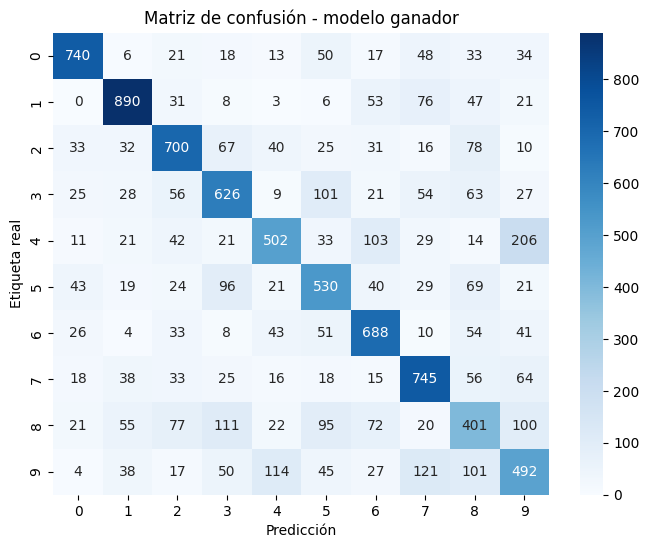

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       980
           1       0.79      0.78      0.79      1135
           2       0.68      0.68      0.68      1032
           3       0.61      0.62      0.61      1010
           4       0.64      0.51      0.57       982
           5       0.56      0.59      0.57       892
           6       0.64      0.72      0.68       958
           7       0.65      0.72      0.68      1028
           8       0.44      0.41      0.42       974
           9       0.48      0.49      0.49      1009

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000

Cantidad de imágenes mal clasificadas: 3686


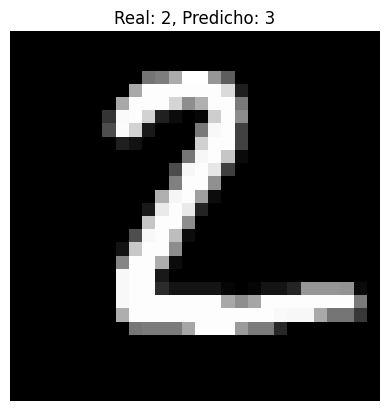

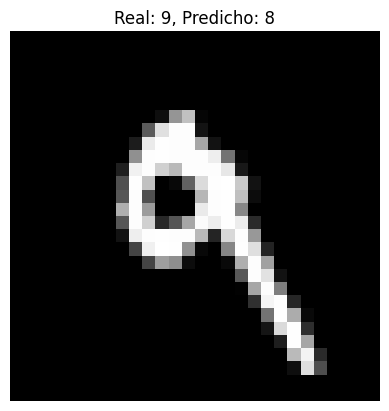

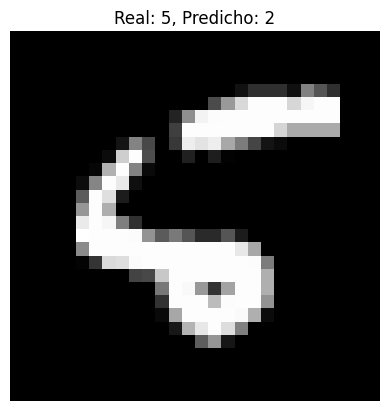

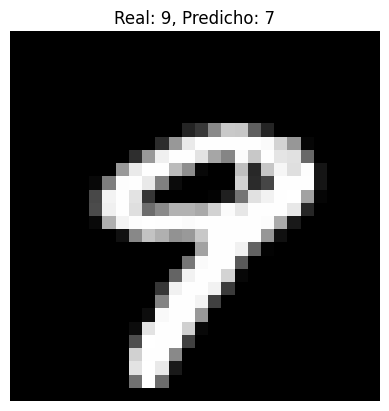

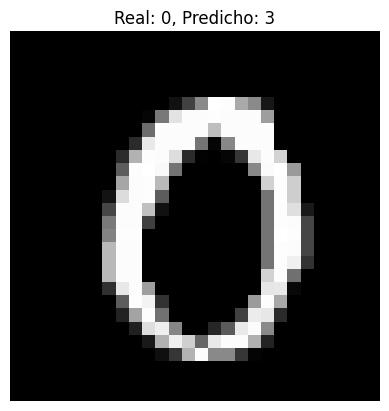

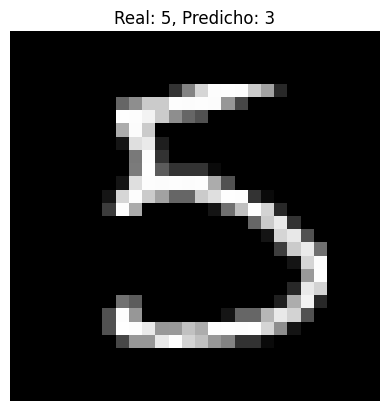

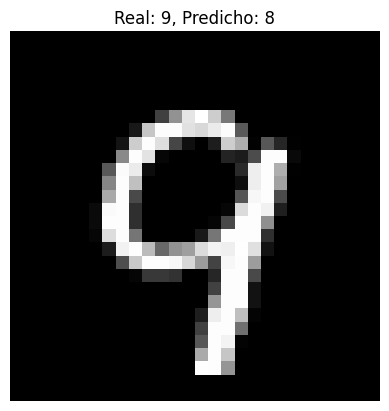

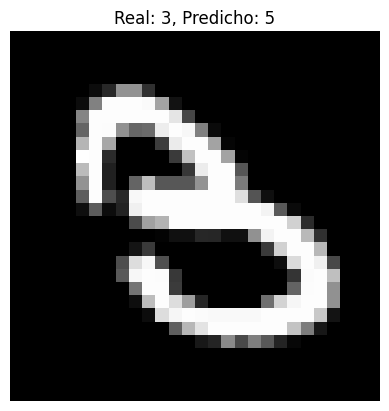

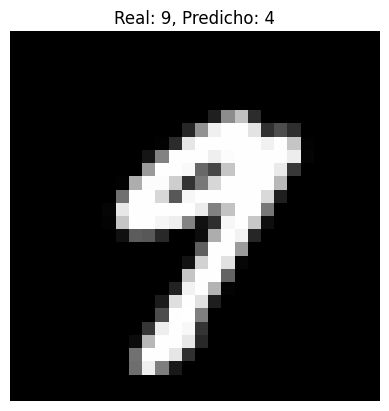

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Elegimos el modelo ganador
best_model = model_aug      # cambia a model_reg si ese resulta mejor
x_test_best = test_images_da  # si usas model_reg sería test_images

# Predicciones en el conjunto de prueba
y_pred_probs = best_model.predict(x_test_best)
y_pred = np.argmax(y_pred_probs, axis=1)

# Matriz de confusión
cm = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión - modelo ganador")
plt.show()

print(classification_report(test_labels, y_pred))
mis_idx = np.where(y_pred != test_labels)[0]
print("Cantidad de imágenes mal clasificadas:", len(mis_idx))

# Mostrar hasta 9 errores
for i in mis_idx[:9]:
    plt.figure()
    plt.imshow(test_images[i], cmap='gray')  # usamos la versión 2D para visualizar
    plt.title(f"Real: {test_labels[i]}, Predicho: {y_pred[i]}")
    plt.axis('off')
    plt.show()


## Evolución del entrenamiento: accuracy, loss y Early Stopping

Para analizar el comportamiento del modelo durante el entrenamiento, se graficaron las curvas de **exactitud (accuracy)** y **pérdida (loss)** tanto para los datos de entrenamiento como para los de validación.  
Estas gráficas permiten identificar si el modelo está aprendiendo de forma adecuada, si aparece sobreajuste, o si el entrenamiento podría detenerse antes.

### 🔹 Curvas de exactitud (accuracy)
La primera gráfica muestra:

- **Accuracy de entrenamiento:** refleja qué tan bien el modelo aprende los datos que ya conoce.
- **Accuracy de validación:** mide el desempeño en datos no vistos, más representativo del rendimiento real.

Una separación grande entre ambas curvas indicaría sobreajuste; en cambio, curvas cercanas señalan buena generalización.

### 🔹 Curvas de pérdida (loss)
La segunda gráfica representa:

- La pérdida sobre el conjunto de entrenamiento.
- La pérdida sobre el conjunto de validación.

Estas curvas ayudan a observar si el modelo converge adecuadamente y si la función de pérdida disminuye de manera estable.

### 🔹 Marcador de Early Stopping
En ambas gráficas aparece una línea vertical roja (`--`), que indica la **época exacta** en la que Early Stopping determinó que el modelo dejó de mejorar su rendimiento en validación.

Gracias a esta técnica:

- Se evita entrenar más tiempo del necesario.
- Se previene el sobreajuste.
- Los pesos finales corresponden al punto donde el modelo obtuvo su mejor desempeño en validación.

### 🔹 Interpretación general
Las gráficas permiten evaluar visualmente que:

- El modelo base aprendió progresivamente durante las primeras épocas.
- El desempeño se estabilizó en la época marcada por Early Stopping.
- La diferencia entre curvas de entrenamiento y validación es un indicador útil para juzgar la capacidad de generalización del modelo.

Estas visualizaciones complementan las métricas numéricas y facilitan la comprensión del proceso de aprendizaje de la red neuronal.


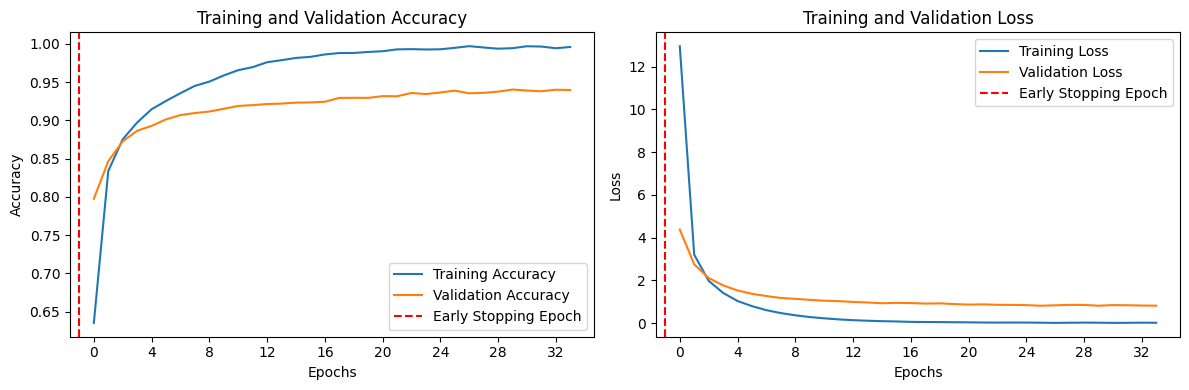

In [25]:
# Plotting the training and validation accuracy
from matplotlib.ticker import MaxNLocator

stopped_epoch = early_stop.stopped_epoch
best_epoch = stopped_epoch - early_stop.patience

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Early Stopping Epoch')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure integer values on x-axis
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Early Stopping Epoch')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure integer values on x-axis
plt.legend()

plt.tight_layout()
plt.show()

## Guardado del modelo final

Una vez identificado el modelo con mejor desempeño —en este caso, el modelo entrenado con *data augmentation*— se procedió a guardarlo para su posterior uso.  
El archivo se almacenó utilizando el formato **HDF5 (.h5)** mediante la función `model.save()` de Keras.

In [31]:
# Save the model
best_model.save("mnist_best_model.h5")
print("Modelo guardado como mnist_best_model.h5")

Modelo guardado como mnist_best_model.h5
